# Import Libraries

In [1]:
import importlib
import os
import math
import time
from collections import OrderedDict
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from scipy.stats import pearsonr, spearmanr
import copy
import bert
import random
import datetime
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from scipy import signal
import scipy.fftpack
import pmdarima as pm
from collections import deque
import pmdarima

from pandas.plotting import lag_plot
from pylab import rcParams
import plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from IPython.display import display, Markdown, clear_output, HTML

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.4f}'.format

# Import function

In [2]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Prod_Sales'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Prod_Sales'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Prod_Sales'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Prod_Sales'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Prod_Sales'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Prod_Sales'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Prod_Sales'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Prod_Sales'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Prod_Sales']/100)-1
    
    return dataset

In [3]:
def plot_technical_indicators(dataset, last_days):
    fig = plt.figure(figsize=(16, 10))
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Prod_Sales'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
    
    return plt

In [4]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [5]:
def timeseries_plot(df, xcol, yxol, split_date, title):
    plt.figure(figsize=(14, 5), dpi=100)
    plt.plot(df[xcol], df[yxol], label='Sales')
    plt.vlines(split_date, 0, 10000, linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel(xcol)
    plt.ylabel(yxol)
    plt.title(title)
    plt.legend()
    plt.show()
    
    return plt

In [6]:
def timeseries_on_multi_freq(df, col):
    df.set_index("Date", inplace=True)

    fig = plt.figure(figsize=(18,16))
    fig.subplots_adjust(hspace=.4)
    ax1 = fig.add_subplot(5,1,1)
    ax1.plot(df[col].resample('D').mean(),linewidth=1)
    ax1.set_title('Mean biosel-50 product sales resampled over day')
    ax1.tick_params(axis='both', which='major')

    ax2 = fig.add_subplot(5,1,2, sharex=ax1)
    ax2.plot(df[col].resample('W').mean(),linewidth=1)
    ax2.set_title('Mean biosel-50 product sales resampled over week')
    ax2.tick_params(axis='both', which='major')

    ax3 = fig.add_subplot(5,1,3, sharex=ax1)
    ax3.plot(df[col].resample('M').mean(),linewidth=1)
    ax3.set_title('Mean biosel-50 product sales resampled over month')
    ax3.tick_params(axis='both', which='major')

    df.reset_index(inplace=True)
    
    return plt

# Dataset

In [10]:
sales_df = pd.read_csv(r'D:\03-Training\Digital\03-SelfLearning\19-Time_Series_Forecasting\data_local\retail_sales.csv')

In [11]:
temp_df = sales_df.loc[(sales_df['District']=='Sitiawan') & (sales_df['Product']=='BIODIESEL B10')]
temp_df = temp_df.drop(['Unnamed: 0'], axis=1)
temp_df['Date'] = pd.to_datetime(temp_df['Date'])

temp_df['Year'] = temp_df['Date'].apply(lambda x: x.year)
temp_df['Day'] = temp_df['Date'].apply(lambda x: x.day)
temp_df['Month_Int'] = temp_df['Month'].astype(int)

temp_df["Weekday"] = temp_df.apply(lambda row: row["Date"].weekday(),axis=1)
temp_df["Weekday"] = (temp_df["Weekday"] < 5).astype(int)

temp_df.index = pd.to_datetime(temp_df.index)

sales_temp_df = temp_df[['Date', 'Prod_Sales']]

print('There are {} number of days in the dataset.'.format(sales_temp_df.shape[0]))

There are 139 number of days in the dataset.


# Feature Generation

In [12]:
train, test = sales_temp_df[0: int(len(sales_temp_df) * 0.75)], sales_temp_df[int(len(sales_temp_df) * 0.75):]
print('Training Dataset: %d, Testing Dataset: %d' % (len(train), len(test)))

Training Dataset: 104, Testing Dataset: 35


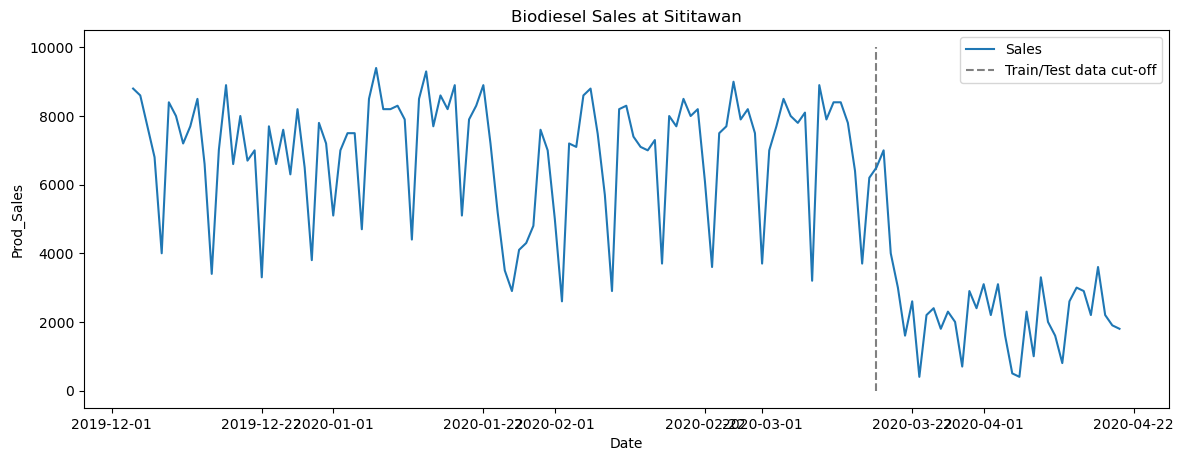

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [13]:
timeseries_plot(sales_temp_df, 'Date', 'Prod_Sales', datetime.date(2020,3,17), 'Biodiesel Sales at Sititawan')

In [14]:
def histogram_probability_plot(df, var, bin_size):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    df[var].hist(bins=bin_size)
    plt.title('Biodiesel Sales')

    plt.subplot(1,2,2)
    stats.probplot(df[var], plot=plt);
    
    return

,count,mean,std,min,25%,50%,75%,max
Prod_Sales,139.0000,"5,809.3525","2,591.4277",400.0000,"3,300.0000","7,000.0000","8,000.0000","9,400.0000"


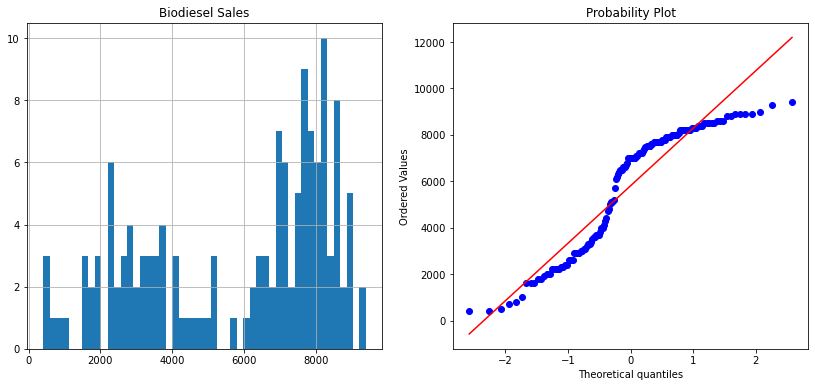

In [15]:
display(sales_temp_df.describe().T)
histogram_probability_plot(sales_temp_df, 'Prod_Sales', 50)

,count,mean,std,min,25%,50%,75%,max
Prod_Sales,139.0000,"5,809.3525","2,591.4277",400.0000,"3,300.0000","7,000.0000","8,000.0000","9,400.0000"


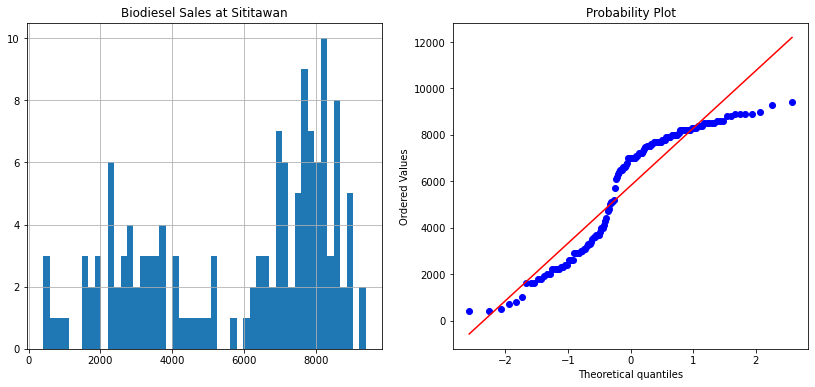

In [16]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sales_temp_df['Prod_Sales'].hist(bins=50)
plt.title('Biodiesel Sales at Sititawan')

plt.subplot(1,2,2)
stats.probplot(sales_temp_df['Prod_Sales'], plot=plt);
sales_temp_df.describe().T

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

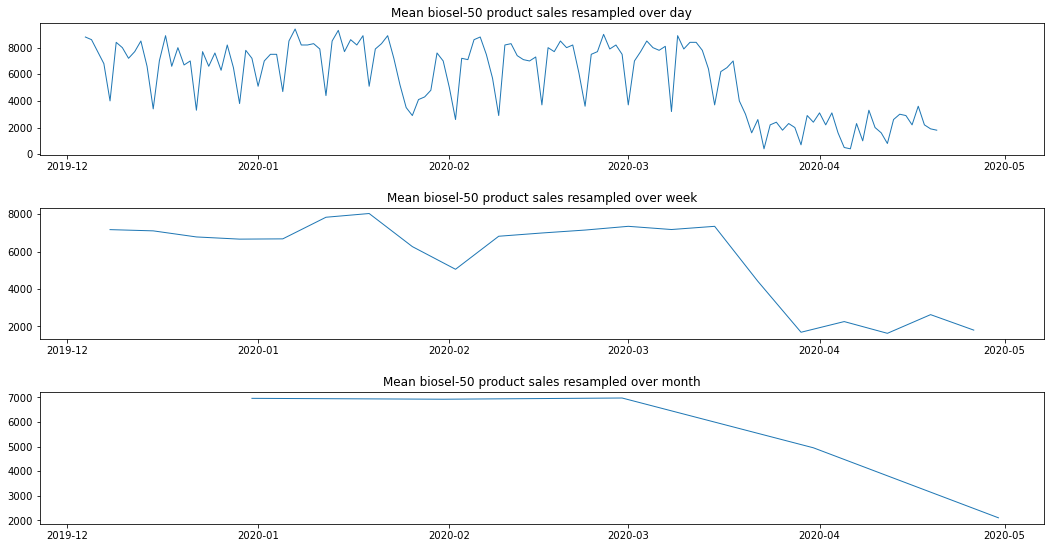

In [17]:
timeseries_on_multi_freq(sales_temp_df, 'Prod_Sales')

## Technical Analysis on Time Series Data

In [18]:
temp_TI_df = get_technical_indicators(sales_temp_df)
temp_TI_df.reset_index(inplace=True)

<h4>List of technical indicators and explanation:</h4>

1. <code>Bollinger bands</code>: Bollinger Bands is used to define the prevailing high and low prices in a market to characterize the trading band of a financial instrument or commodity. Bollinger Bands are a volatility indicator. Bands are consists of Moving Average (MA) line, a upper band and lower band. The upper and lower bands are simply MA adding and subtracting standard deviation.

2. <code>EMA</code>: Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company\'s closing price are trending for a given amount of days. example for 4 days is price was 22,23 ,45,1 (the company crashed on 4th day) the average would be 23. Now 23 is a below average value so it gives us an idea that 45 was indeed just a fluke and that infact the company was always making losses EMA is calculated as: EMA(t)EMA(t0)=(1−α)EMA(t−1)+α p(t)=p(t0) where α=1L+1 and length of window is α=2M+1 I used the ewm(exponential weighted mean ) function to calculate ema.

3. <code>Momentum</code>: Momentum is perhaps the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset.

The formula for momentum is: $Momentum=V−Vx$ where:, $V$ = Latest price, $Vx$ = Closing price, $x$ = Number of days ago

Other features calculated are moving averages of 7 and 21 days and standard deviation.

<h4>Resources</h4>

<a href="https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/" target="_top">Moving Average Trading Strategy</a>

<a href="https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861" target="_top">Trading: Calculate Technical Analysis Indicators with Pandas</a>

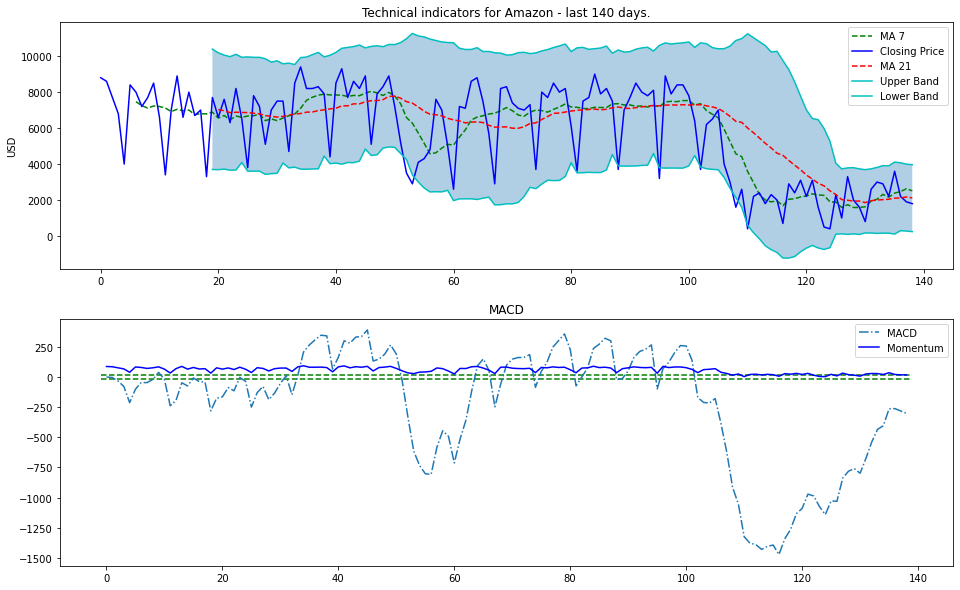

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [19]:
display(Markdown(r'<h4>List of technical indicators and explanation:</h4>'))
display(Markdown(r'1. <code>Bollinger bands</code>: Bollinger Bands is used to define the prevailing high and low prices in a market to characterize the trading band of a financial instrument or commodity. Bollinger Bands are a volatility indicator. Bands are consists of Moving Average (MA) line, a upper band and lower band. The upper and lower bands are simply MA adding and subtracting standard deviation.'))

display(Markdown(r'2. <code>EMA</code>: Exponential moving average is a better version of a simple moving average that doesnt have SMAs lag. Moving averages just average out the data for a given time so we know how the company\'s closing price are trending for a given amount of days. example for 4 days is price was 22,23 ,45,1 (the company crashed on 4th day) the average would be 23. Now 23 is a below average value so it gives us an idea that 45 was indeed just a fluke and that infact the company was always making losses EMA is calculated as: EMA(t)EMA(t0)=(1−α)EMA(t−1)+α p(t)=p(t0) where α=1L+1 and length of window is α=2M+1 I used the ewm(exponential weighted mean ) function to calculate ema.'))

display(Markdown(r'3. <code>Momentum</code>: Momentum is perhaps the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset.'))

display(Markdown(r'The formula for momentum is: $Momentum=V−Vx$ where:, $V$ = Latest price, $Vx$ = Closing price, $x$ = Number of days ago'))

display(Markdown(r'Other features calculated are moving averages of 7 and 21 days and standard deviation.'))

display(Markdown(r'<h4>Resources</h4>'))
display(Markdown(r'<a href="https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/" target="_top">Moving Average Trading Strategy</a>'))
display(Markdown(r'<a href="https://towardsdatascience.com/trading-technical-analysis-with-pandas-43e737a17861" target="_top">Trading: Calculate Technical Analysis Indicators with Pandas</a>'))

plot_technical_indicators(temp_TI_df, 140)

## Analysis using Fourier Transform

In [20]:
data_FT = sales_temp_df
close_fft = np.fft.fft(np.asarray(data_FT['Prod_Sales'].tolist()))
fft_df = pd.DataFrame({'FFT': close_fft})
fft_df['Absolute'] = fft_df['FFT'].apply(lambda x: np.abs(x))
fft_df['Angle'] = fft_df['FFT'].apply(lambda x: np.angle(x))

In [21]:
def frequency_plot(df, var):
    fig = plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['FFT'].tolist())
    for num_ in [3, 6, 9, 25]:
        fft_list_m10= np.copy(fft_list); 
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(df[var],  label='Real')
    plt.xlabel('Days')
    plt.ylabel(var)
    plt.title('Fourier transforms of {}'.format(var))
    plt.legend()
    plt.show()
    
    return plt

<h4>Technical explanation on FFT:</h4>

1. <code>Fourier Transform</code>: Uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it\'s reconverted into time domain where it\'s plotted. Fourier Transform as indicator helps to extract predominate cycle from a series of data

<h4>Resources</h4>

<a href="https://www.metastock.com/customer/resources/taaz/?p=58" target="_top">Fourier Transform</a>

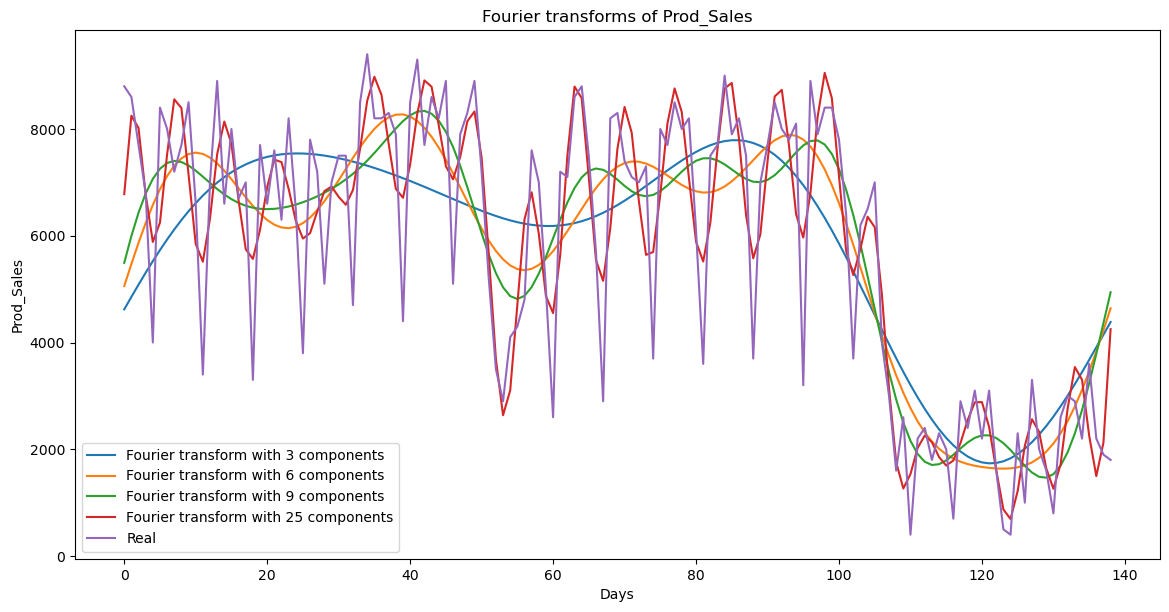

<module 'matplotlib.pyplot' from 'C:\\Users\\kew.jingsheng\\AppData\\Local\\Continuum\\anaconda3\\envs\\ts_forecasting\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [22]:
display(Markdown(r'<h4>Technical explanation on FFT:</h4>'))
display(Markdown(r'1. <code>Fourier Transform</code>: Uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it\'s reconverted into time domain where it\'s plotted. Fourier Transform as indicator helps to extract predominate cycle from a series of data'))

display(Markdown(r'<h4>Resources</h4>'))
display(Markdown(r'<a href="https://www.metastock.com/customer/resources/taaz/?p=58" target="_top">Fourier Transform</a>'))

frequency_plot(data_FT, 'Prod_Sales')

In [23]:
data = sales_temp_df
x_var = 'Date'
y_var = 'Prod_Sales'
period_on_fft = 50

data_FT = data[[x_var, y_var]]
data_FT['Fourier'] = np.fft.fft(np.asarray(data_FT['Prod_Sales'].tolist()))
data_FT['Absolute'] = data_FT['Fourier'].apply(lambda x: np.abs(x))
data_FT['Angle'] = data_FT['Fourier'].apply(lambda x: np.angle(x))

In [24]:
fft_list = np.asarray(fft_df['FFT'].tolist())
fft_list_m10 = np.copy(fft_list)
fft_list_m10[period_on_fft : -period_on_fft] = 0
data['Fourier_{}'.format(period_on_fft)] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))

In [25]:
def get_fourier(data, x_var, y_var, period_on_fft):
    data_FT = data[[x_var, y_var]]
    temp_fft = np.fft.fft(np.asarray(data_FT[y_var].tolist()))
    temp_fft = np.fft.ifft(temp_fft)

    fft_df = pd.DataFrame({'FFT':temp_fft})
    fft_df['Absolute'] = fft_df['FFT'].apply(lambda x: np.abs(x))
    fft_df['Angle'] = fft_df['FFT'].apply(lambda x: np.angle(x))
    
    fft_list = np.asarray(fft_df['FFT'].tolist())
    fft_list_m10 = np.copy(fft_list); 
    fft_list_m10[period_on_fft : -period_on_fft] = 0
    data['Fourier_{}'.format(period_on_fft)] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    return data

In [26]:
dataset_TI_df = get_fourier(sales_temp_df, 'Date', 'Prod_Sales', 50)

## ARIMA as feature

In [27]:
series = sales_temp_df['Prod_Sales']
model = ARIMA(series, order=(6, 1, 1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Prod_Sales   No. Observations:                  138
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -1193.824
Method:                       css-mle   S.D. of innovations           1367.006
Date:                Sun, 26 Jul 2020   AIC                           2405.648
Time:                        23:58:15   BIC                           2431.993
Sample:                             1   HQIC                          2416.354
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -40.1843     30.473     -1.319      0.187     -99.909      19.541
ar.L1.D.Prod_Sales    -0.8656      0.088     -9.825      0.000      -1.038      -0.693
ar.L2.D.Prod_Sales  

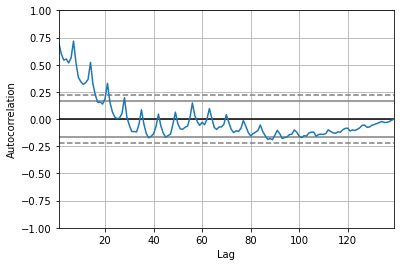

<Figure size 3600x2400 with 0 Axes>

In [28]:
autocorrelation_plot(series)
plt.figure(figsize=(45, 30), dpi=80)
plt.show()

In [29]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(6, 1, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

try:
    dataset_TI_df = dataset_TI_df.drop(['level_0'], axis=1)
except:
    pass

In [30]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 2352303.401


In [34]:
def myFun(*args,**kwargs): 
    print("args: ", args) 
    print("kwargs: ", kwargs) 
  
myFun('geeks','for','geeks',first="Geeks",mid="for",last="Geeks")

args:  ('geeks', 'for', 'geeks')
kwargs:  {'first': 'Geeks', 'mid': 'for', 'last': 'Geeks'}


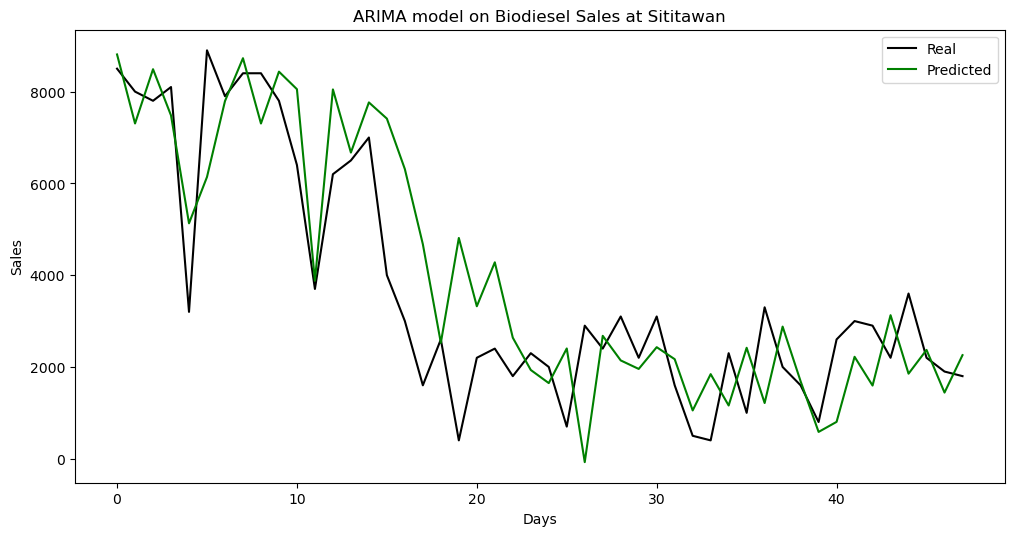

In [31]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='green', label='Predicted')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('ARIMA model on Biodiesel Sales at Sititawan')
plt.legend()
plt.show()

In [32]:
print('Total dataset has {} samples, and {} features.'.format(sales_temp_df.shape[0], sales_temp_df.shape[1]))

Total dataset has 139 samples, and 15 features.


In [33]:
dataset_TI_df

,index,Date,Prod_Sales,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier_50,ARIMA
0,0,2019-12-04,"8,800.0000",nan,nan,"8,800.0000","8,800.0000",0.0000,nan,nan,nan,"8,800.0000",87.0000,"8,800.0000","8,809.6947"
1,1,2019-12-05,"8,600.0000",nan,nan,"8,696.1538","8,691.6667",-4.4872,nan,nan,nan,"8,650.0000",85.0000,"8,600.0000","7,305.8073"
2,2,2019-12-06,"7,700.0000",nan,nan,"8,338.2454","8,304.6189",-33.6265,nan,nan,nan,"7,992.3077",76.0000,"7,700.0000","8,488.2459"
3,3,2019-12-07,"6,800.0000",nan,nan,"7,908.2192","7,829.6695",-78.5497,nan,nan,nan,"7,187.5000",67.0000,"6,800.0000","7,480.4008"
4,4,2019-12-08,"4,000.0000",nan,nan,"7,001.8871","6,789.1620",-212.7251,nan,nan,nan,"5,053.7190",39.0000,"4,000.0000","5,130.2523"
5,5,2019-12-09,"8,400.0000",nan,nan,"7,281.9179","7,180.6804",-101.2376,nan,nan,nan,"7,287.6374",83.0000,"8,400.0000","6,140.1069"
6,6,2019-12-10,"8,000.0000","7,471.4286",nan,"7,409.6251","7,363.5087",-46.1164,nan,nan,nan,"7,762.7630",79.0000,"8,000.0000","7,793.7791"
7,7,2019-12-11,"7,200.0000","7,242.8571",nan,"7,375.8493","7,329.3870",-46.4624,nan,nan,nan,"7,387.5305",71.0000,"7,200.0000","8,728.0295"
8,8,2019-12-12,"7,700.0000","7,114.2857",nan,"7,423.8956","7,402.7074",-21.1882,nan,nan,nan,"7,595.8541",76.0000,"7,700.0000","7,305.0298"
9,9,2019-12-13,"8,500.0000","7,228.5714",nan,"7,572.3875","7,610.6439",38.2564,nan,nan,nan,"8,198.6282",84.0000,"8,500.0000","8,434.8531"


## Gaussian Process for Time Series Forecasting

In [42]:
import GPy
from sklearn.impute import KNNImputer
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, Matern, RBF, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [43]:
def to_integer(dt_time):
    return (10000*dt_time.year) + (100*dt_time.month) + (dt_time.day)

In [44]:
imputer = KNNImputer(n_neighbors=3)

noise = 0.4
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
mixed_kernel = kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

gpr = GaussianProcessRegressor(kernel=rbf, 
                               alpha=noise, 
                               n_restarts_optimizer=0, 
                               normalize_y=False, 
                               optimizer='fmin_l_bfgs_b', 
                               random_state=None)

In [45]:
sales_data = sales_temp_df.set_index('Date')
sales_data = imputer.fit_transform(sales_data)

In [46]:
sales_data = sales_temp_df[['Date', 'Prod_Sales', 'ARIMA']]
# sales_data['Date_Int'] = sales_data['Date'].apply(lambda x: to_integer(x))
sales_data = sales_data.set_index('Date')
sales_temp_df = sales_temp_df.drop(['index'], axis=1)
sales_temp_df = sales_temp_df.set_index('Date')

x = sales_temp_df.drop(['Prod_Sales'], axis=1)
# x = sales_temp_df[['26ema']].values
x = imputer.fit_transform(x)
y = sales_temp_df[['Prod_Sales']].values
y = imputer.fit_transform(y)

train_size = int(len(sales_data) * 0.7)

# x = sales_data['Date_Int'].values.reshape(sales_data.shape[0], 1)
x_train = x[0 : train_size]
x_test = x[train_size : len(sales_data)]

# y = sales_temp_df['Prod_Sales'].values.reshape(sales_data.shape[0], 1)
y_train = y[0 : train_size]
y_test = y[train_size : len(sales_data)]

In [47]:
gpr.fit(x, y)

GaussianProcessRegressor(alpha=0.4, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [48]:
#Generate predictions.
y_pred, y_std = gpr.predict(x, return_std=True)

sales_data['y_pred'] = y_pred
sales_data['y_std'] = y_std
sales_data['y_pred_lwr'] = sales_data['y_pred'] - sales_data['y_std']
sales_data['y_pred_upr'] = sales_data['y_pred'] + sales_data['y_std']

[Text(0, 0.5, 'Prod_Sales'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Gaussian Process Prediction')]

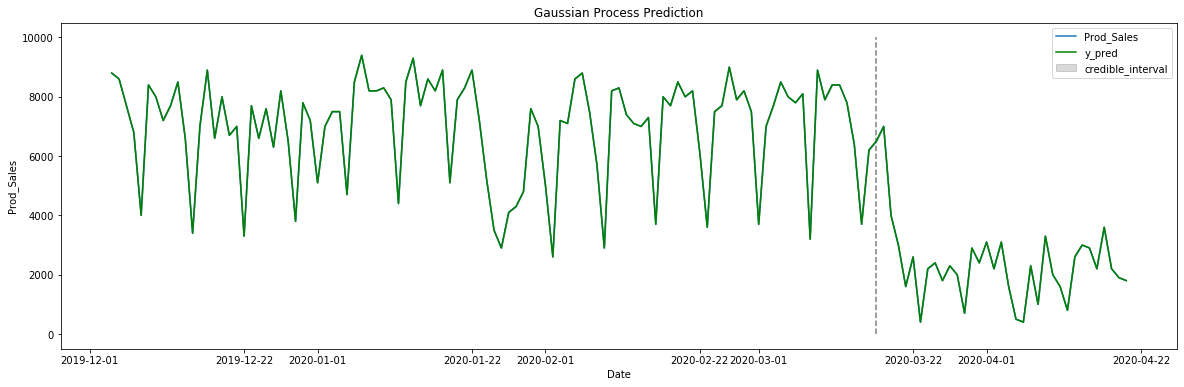

In [49]:
SPLIT_DATE = datetime.date(2020,3,17)
sales_data = sales_data.reset_index()

fig, ax = plt.subplots(figsize=(20, 6))

ax.fill_between(
    x=sales_data['Date'], 
    y1=sales_data['y_pred_lwr'], 
    y2=sales_data['y_pred_upr'], 
    color='black', 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='Date', y='Prod_Sales', data=sales_data, label = 'Prod_Sales', ax=ax)
sns.lineplot(x='Date', y='y_pred', data=sales_data, label='y_pred', color='green', ax=ax)

plt.vlines(SPLIT_DATE, 0, 10000, linestyles='--', colors='gray', label='Train/Test data cut-off')
ax.set(title='Gaussian Process Prediction', xlabel='Date', ylabel='Prod_Sales')

## Hidden Markov Model

In [50]:
from hmmlearn.hmm import GaussianHMM

In [51]:
sales_temp_df = sales_temp_df.reset_index()
sales_data = sales_temp_df[['Date', 'Prod_Sales']]
sales_data['Date_Int'] = sales_data['Date'].apply(lambda x: to_integer(x))

train_size = int(len(sales_data) * 0.75)

data = sales_data['Prod_Sales'].values.reshape(sales_data.shape[0], 1)
train = data[0 : train_size]
test = data[train_size : len(data)]

In [52]:
NUM_COMPONENTS = 8
COVARIANCE = "diag"
ITERATION = 1000

model = GaussianHMM(n_components=NUM_COMPONENTS, covariance_type=COVARIANCE, n_iter=ITERATION)
model.fit(train)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=8, n_iter=1000, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [53]:
hidden_state = model.predict(test)

In [54]:
print('\nMeans and variances of hidden states:')
for i in range(model.n_components):
    print('\nHidden State', i+1)
    print('Mean = ', round(model.means_[i][0], 3))
    print('Variance =', round(np.diag(model.covars_[i])[0], 3))


Means and variances of hidden states:

Hidden State 1
Mean =  3691.291
Variance = 603705.431

Hidden State 2
Mean =  7509.206
Variance = 496805.184

Hidden State 3
Mean =  7991.971
Variance = 83257.139

Hidden State 4
Mean =  6873.639
Variance = 392203.865

Hidden State 5
Mean =  3538.056
Variance = 97181.024

Hidden State 6
Mean =  4928.976
Variance = 82265.525

Hidden State 7
Mean =  8583.009
Variance = 153015.39

Hidden State 8
Mean =  7350.069
Variance = 78157.311


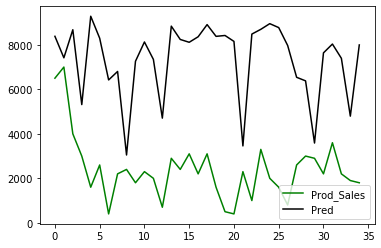

In [55]:
NUM_SAMPLES = test.shape[0]
samples, _ = model.sample(NUM_SAMPLES)
plt.plot(np.arange(NUM_SAMPLES), test, c='green', label='Prod_Sales')
plt.plot(np.arange(NUM_SAMPLES), samples, c='black', label='Pred')
plt.legend()
plt.show()

## Fuzzy Time Series

## Get Feature Importance with XGBoost 

In [42]:
def get_feature_importance_data(dataset):
    data = dataset.copy()
    y = data['Prod_Sales']
    X = data.iloc[:, 2:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [43]:
# Get training and test data
dataset_TI_df.drop(['index'], axis=1, inplace=True)
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

regressor = XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

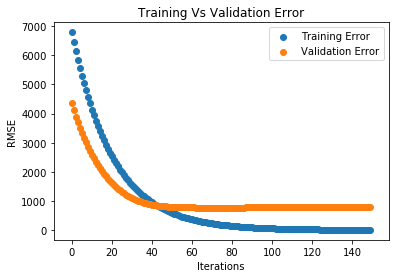

In [44]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

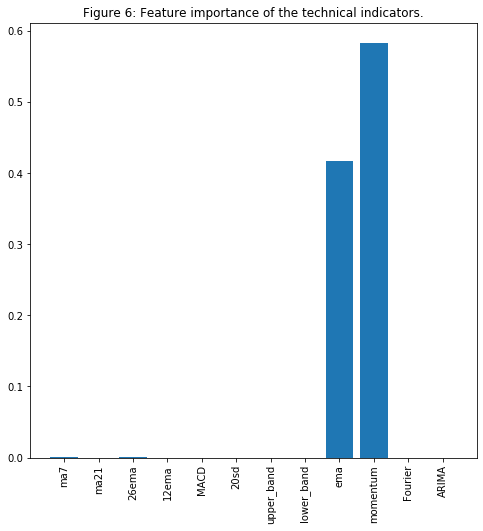

In [45]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

# Extracting high-level features with Stacked Autoencoders

## Activation Function - GELU (Gaussian Error)

In [46]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

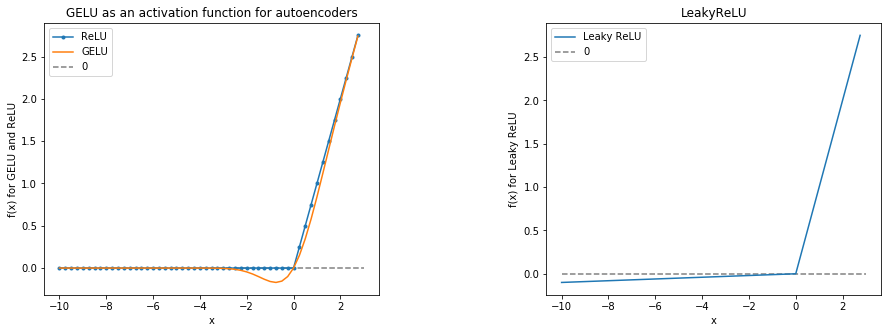

In [47]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('LeakyReLU')
plt.legend()

plt.show()

# Modelling

## Univariate LSTM

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPool2D, Flatten, GRU, CuDNNLSTM, TimeDistributed
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from livelossplot import PlotLossesKeras
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [49]:
# convert an array of values into a dataset matrix

def sliding_windows(dataset, step_size):
    X, Y = [], []
    for i in range(len(dataset) - step_size):
        X.append(dataset[i:(i + step_size), 0])
        Y.append(dataset[i + step_size, 0])
    return np.array(X), np.array(Y)

In [50]:
sales_data = sales_temp_df[['Date', 'Prod_Sales']]

model_data = sales_temp_df['Prod_Sales'].values
model_data = model_data.astype('float32')
model_data = np.reshape(model_data, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

train_size = int(len(model_data) * 0.60)

train, test = model_data[0 : train_size, :], model_data[train_size : len(model_data), :]
print('Total model_data has {} samples, and {} features.'.format(len(train), len(test)))

Total model_data has 83 samples, and 56 features.


In [51]:
# # reshape into X=t and Y=t+1
step_size = 7
x_train, y_train = sliding_windows(train, step_size)
x_test, y_test = sliding_windows(test, step_size)

# # reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(LSTM(units=50))
model.add(Dropout(rate=0.2))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1)

model = Sequential()
model.add(LSTM(units=128, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units=64))
# model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=1, shuffle=False)
#callbacks=[EarlyStopping(monitor='val_loss', patience=80)]

model.summary()

In [52]:
model = keras.Sequential()
model.add(
    LSTM(
        units=128, 
        input_shape=(x_train.shape[1], x_train.shape[2]))
)
    
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [53]:
history = model.fit(
    x_train, y_train, 
    epochs=30, 
    batch_size=70,
    validation_split=0.1,
    shuffle=False,
    verbose=1,
)

print(model.summary())


Train on 68 samples, validate on 8 samples
Epoch 1/30
68/68 [==============================] - 0s 5ms/step - loss: 0.6381 - val_loss: 0.5961
Epoch 2/30
68/68 [==============================] - 0s 206us/step - loss: 0.5450 - val_loss: 0.4970
Epoch 3/30
68/68 [==============================] - 0s 205us/step - loss: 0.4513 - val_loss: 0.4086
Epoch 4/30
68/68 [==============================] - 0s 219us/step - loss: 0.3667 - val_loss: 0.3344
Epoch 5/30
68/68 [==============================] - 0s 205us/step - loss: 0.3077 - val_loss: 0.2668
Epoch 6/30
68/68 [==============================] - 0s 220us/step - loss: 0.2396 - val_loss: 0.2062
Epoch 7/30
68/68 [==============================] - 0s 191us/step - loss: 0.1892 - val_loss: 0.1520
Epoch 8/30
68/68 [==============================] - 0s 220us/step - loss: 0.1450 - val_loss: 0.1067
Epoch 9/30
68/68 [==============================] - 0s 205us/step - loss: 0.0992 - val_loss: 0.0712
Epoch 10/30
68/68 [==============================] - 0s 23

In [54]:
def root_mean_squared_error(y_pred, y_test):
    rmse = np.sqrt(np.mean(y_pred - y_test)**2)
    return rmse

train_predict = model.predict(x_train)
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:', root_mean_squared_error(train_predict[:,0], y_train[0]))

test_predict = model.predict(x_test)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:', root_mean_squared_error(test_predict[:,0], y_test[0]))

Train Mean Absolute Error: 1836.6066908185937
Train Root Mean Squared Error: 960.1033743215063
Test Mean Absolute Error: 1322.454617027217
Test Root Mean Squared Error: 238.29757818967008


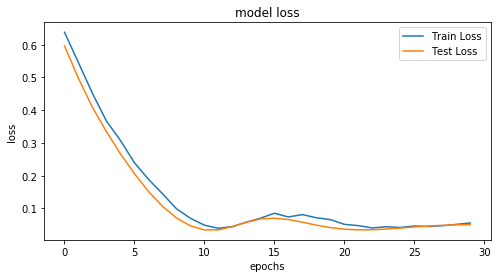

In [55]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

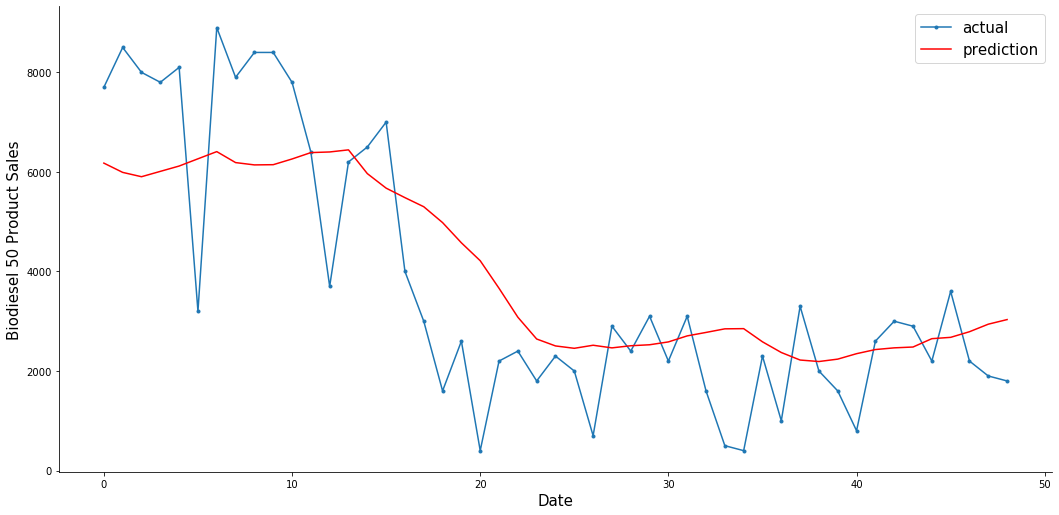

In [56]:
test_data = [x for x in range(y_test.shape[1])]
plt.figure(figsize=(15,7))
plt.plot(test_data, y_test[0][:y_test.shape[1]], marker='.', label="actual")
plt.plot(test_data, test_predict[:,0][:y_test.shape[1]], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Biodiesel 50 Product Sales', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
def create_model():
    model = Sequential()
    model.add(CuDNNLSTM(4, input_shape=(look_back, num_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.391))
    
    #1
    for _ in range(2):
        model.add(CuDNNLSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(CuDNNLSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.749))
    
    #3
    for _ in range(0):
        model.add(Dense(4, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.056))
    #3
    for _ in range(8):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.212))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.727))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.450))
        
    model.add(Dense(1))
    
    return model

In [ ]:
"""
Look back , 5
nodes, 35

More only makes the model more complex and harder/slower to train
"""

epochs = 10**2
bs = 256
lr = 1e-1
print(bs)

In [ ]:
# 0.05 0.9 0 True
sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

model = create_model()

# compile & fit
model.compile(optimizer='adam', loss = ['mse'], metrics=[mape, smape, 'mse'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5000)

# This is used to save the best model, currently monitoring val_mape
# checkpoint
filepath="models\\LSTM.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mape', verbose=1, save_best_only=True, mode='min')

epoch_size = 14
schedule = SGDRScheduler(min_lr=2.3e-6, #1e-5
                                     max_lr=3.5e-2, # 1e-2
                                     steps_per_epoch=np.ceil(epoch_size/bs),
                                     lr_decay=0.9,
                                     cycle_length=5, # 5
                                     mult_factor=1.5)

model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_split=0.2,
         verbose=1, callbacks=[PlotLossesKeras(), early_stopping_monitor, checkpoint,schedule])
 
print(model.summary())